#### Predictive model to anticipate timely maintenance of devices based on daily telemetry 

- Goals : Maintenance cost reduction through predictive techniques
- Data source : http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv


##### Summary of the dataset
- Number of total observations: 124494
- Unique ids (unique device sensors): Total 1169 (No failure 1063, With failure 106)
- Length of observations varies from 1 to 304

##### Steps in the analysis
- Read the input data file
- Convert the date column to pandas datetime
- Calculate rolling averages and standard deviation for 5 periods
- Label the last 'n' time points as failure before sensors fail
- Identify sensors with less than 10 measurement (may indicate sensors that have manufacturing defect)
- Build and test models with all sensors and without sensor with less than 10 measurements

##### Challenges
- Some sensors have intermintant measurements which can result in missing values in rolling window
- IDs that lack multiple timepoints just proir to failure day

##### Improvements
- Write functions for similar tasks
- Redo the model with sensors having the last 10 days of consistent measurements
 * Last period is crucial and may contain important clues about possible events before failure
- Select sensors which have atleast 50 days of total reading
 * Sensors that fail too early may have manufacturing defects.
 * Failure after long time frame may be a result of wear and tear.
- Have more granular timepoint from sensors
- Keep improving the model for sensors unable to be predicted

##### References for background and modeling approaches
- https://github.com/aws-samples/amazon-sagemaker-architecting-for-ml/blob/master/Writeups/Predictive_Maintenance.md
- https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance
- https://notebooks.azure.com/Microsoft/projects/PredictiveMaintenance/html/Predictive%20Maintenance%20Modeling%20Guide%20Python%203%20Notebook.ipynb

In [39]:
## libraries

import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import operator


## plotting
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
%matplotlib inline

## ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score, roc_curve, auc, f1_score, confusion_matrix

## data
url = r'http://aws-proserve-data-science.s3.amazonaws.com/predictive_maintenance.csv'


In [2]:
## Read the data and perform QC

maintain_df = pd.read_csv(url)


## covert data to datetime
maintain_df['date'] = pd.to_datetime(maintain_df['date'], format="%Y-%m-%d")
#maintain_df = maintain_df.set_index('date')
#opsd_daily.head(3)
#maintain_df['date'] = maintain_df['date'].values.astype(float)
print(maintain_df.shape)
print(maintain_df['id'].nunique())
maintain_df.head()

(124494, 12)
1169


,date,id,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [3]:
maintain_df.describe()

,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
count,124494.000000,1.244940e+05,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000,124494.000000
mean,0.000851,1.223881e+08,159.484762,9.940455,1.741120,14.222669,260172.657726,0.292528,0.292528,12.451524
std,0.029167,7.045933e+07,2179.657730,185.747321,22.908507,15.943028,99151.078547,7.436924,7.436924,191.425623
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,8.000000,0.000000,0.000000,0.000000
25%,0.000000,6.128476e+07,0.000000,0.000000,0.000000,8.000000,221452.000000,0.000000,0.000000,0.000000
50%,0.000000,1.227974e+08,0.000000,0.000000,0.000000,10.000000,249799.500000,0.000000,0.000000,0.000000
75%,0.000000,1.833096e+08,0.000000,0.000000,0.000000,12.000000,310266.000000,0.000000,0.000000,0.000000
max,1.000000,2.441405e+08,64968.000000,24929.000000,1666.000000,98.000000,689161.000000,832.000000,832.000000,18701.000000


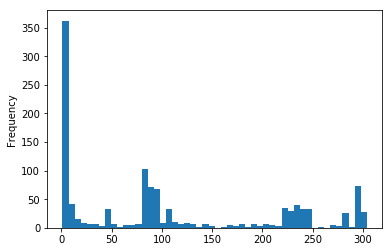

In [4]:
count_id = maintain_df.groupby(['id'])['failure'].count().sort_values(ascending=False)

count_id.plot.hist(bins=50)

##### Distribution of sample with and without failures (Number of TOTAL OBSERVATIONS)

             count      nunique
count  1169.000000  1169.000000
mean    106.496151     1.090676
std     102.651601     0.287270
min       1.000000     1.000000
25%       6.000000     1.000000
50%      84.000000     1.000000
75%     224.000000     1.000000
max     304.000000     2.000000


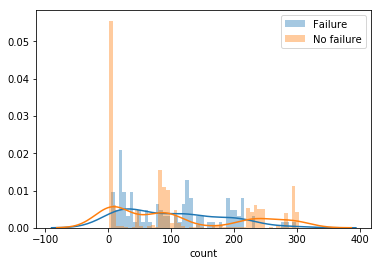

In [5]:
count_id = pd.DataFrame(maintain_df.groupby(['id'])['failure'].agg(['count','nunique']).sort_values(by='nunique',ascending=False))

print(count_id.describe())
sns.distplot(count_id[count_id['nunique']==2]['count'], hist=True, bins=50, rug=False, label='Failure')
sns.distplot(count_id[count_id['nunique']==1]['count'], hist=True, bins=50, rug=False, label='No failure')
plt.legend()

In [6]:
print(count_id.groupby('nunique')['nunique'].count())
count_id.reset_index(inplace=True)

## select sensors less than 10 days of measurement
sensors_less = count_id[(count_id['count']<=10)]['id'].tolist()
print(len(sensors_less))

nunique
1    1063
2     106
Name: nunique, dtype: int64
366


In [7]:
#### Last day statistics

count_id = pd.DataFrame(maintain_df.groupby(['id'],as_index=False).agg(['last']))
count_id.columns = count_id.columns.droplevel(1) 
print(count_id.shape)
count_id.tail()
print(count_id.groupby('failure')['failure'].count())

(1169, 11)
failure
0    1068
1     101
Name: failure, dtype: int64


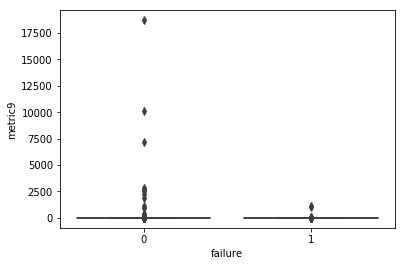

In [8]:
#### Plot the last day statistics between failure and no failure

ax = sns.boxplot(x="failure", y="metric9", data=count_id)
#count_id[]

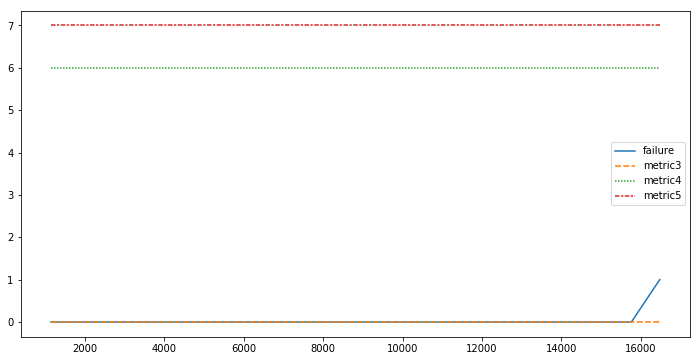

In [9]:
## plot the raw values for one sensor with failure

subset_df = maintain_df[maintain_df['id']=='Z1F1FCH5']
subset_df = subset_df.drop(['id','date','metric1', 'metric2','metric8', 'metric6', 'metric7', 'metric9'], axis=1)

col_select = subset_df.columns
wide_df = subset_df[col_select]

# figure size
plt.figure(figsize=(12,6))

# timeseries plot using lineplot
sns.lineplot(data=wide_df)

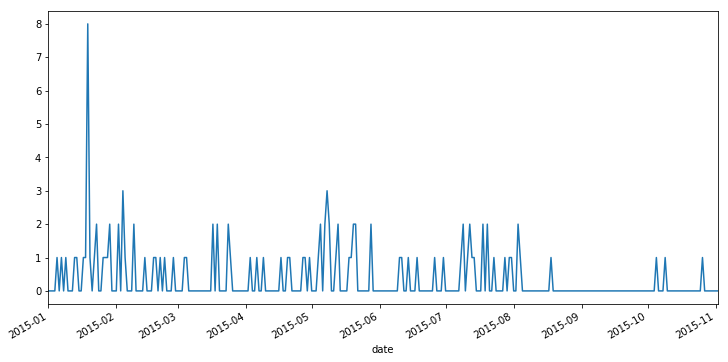

In [10]:
## Plot number of failures by date
plt.figure(figsize=(12,6))
maintain_df.groupby(['date'])['failure'].sum().plot()

#### Feature engineering using rolling window

In [11]:
## Calculate rolling mean values for telemetry features
temp = []
features = ['metric' + str(x) for x in range(1,10)]
for col in features:
    temp.append(pd.pivot_table(maintain_df,
                               index='date',
                               columns='id',
                               values=col).rolling(window=5).mean().unstack())
    
maintain_mean_5d = pd.concat(temp, axis=1)
maintain_mean_5d.columns = [i + '_mean_5d' for i in features]
maintain_mean_5d.reset_index(inplace=True)
maintain_mean_5d = maintain_mean_5d.loc[-maintain_mean_5d['metric1_mean_5d'].isnull()]
maintain_mean_5d.head()


# repeat for standard deviation
temp = []
features = ['metric' + str(x) for x in range(1,10)]
for col in features:
    temp.append(pd.pivot_table(maintain_df,
                               index='date',
                               columns='id',
                               values=col).rolling(window=5).std().unstack())

maintain_sd_5d = pd.concat(temp, axis=1)
maintain_sd_5d.columns = [i + '_std_5d' for i in features]
maintain_sd_5d.reset_index(inplace=True)
maintain_sd_5d = maintain_sd_5d.loc[-maintain_sd_5d['metric1_std_5d'].isnull()]
maintain_sd_5d.head()

,id,date,metric1_std_5d,metric2_std_5d,metric3_std_5d,metric4_std_5d,metric5_std_5d,metric6_std_5d,metric7_std_5d,metric8_std_5d,metric9_std_5d
4,S1F01085,2015-01-05,7.668639e+07,0.0,0.0,0.0,0.0,302.204897,0.0,0.0,0.0
5,S1F01085,2015-01-06,5.430312e+07,0.0,0.0,0.0,0.0,855.137884,0.0,0.0,0.0
433,S1F013BB,2015-05-10,1.023539e+08,0.0,0.0,0.0,0.0,51.788030,0.0,0.0,0.0
434,S1F013BB,2015-05-11,8.457176e+07,0.0,0.0,0.0,0.0,84.461234,0.0,0.0,0.0
612,S1F0166B,2015-01-05,7.489762e+07,0.0,0.0,0.0,0.0,285.210799,0.0,0.0,0.0


In [12]:
## Merge mean and std data

maintain_mean_std_5d = maintain_mean_5d.merge(maintain_sd_5d, on=['id','date'], how='left')

#### Labels for telemetry sensors and window prior to failure

In [13]:
## Engineer the label 'failure'

failure_df = maintain_df[['id','date','failure']]
failure_df['failure'] = failure_df['failure'].replace({ 0:np.nan})
#failure_df.head()

D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [14]:
## Merge rolling mean dataframe with failure information
labeled_df = maintain_mean_std_5d.merge(failure_df, on=['id','date'], how='left')

## backfill the number of days before failure as '1' and the remaining NaN as '0'
labeled_df['failure'] = labeled_df['failure'].fillna(method='bfill', limit=5)
labeled_df['failure'] = labeled_df['failure'].fillna(0)
labeled_df['failure'] = labeled_df['failure'].astype(int)
labeled_df.reset_index(inplace=True,drop=True)
labeled_df.head()

,id,date,metric1_mean_5d,metric2_mean_5d,metric3_mean_5d,metric4_mean_5d,metric5_mean_5d,metric6_mean_5d,metric7_mean_5d,metric8_mean_5d,...,metric1_std_5d,metric2_std_5d,metric3_std_5d,metric4_std_5d,metric5_std_5d,metric6_std_5d,metric7_std_5d,metric8_std_5d,metric9_std_5d,failure
0,S1F01085,2015-01-05,113353115.2,56.0,0.0,52.0,6.0,407573.4,0.0,0.0,...,7.668639e+07,0.0,0.0,0.0,0.0,302.204897,0.0,0.0,0.0,0
1,S1F01085,2015-01-06,95993406.4,56.0,0.0,52.0,6.0,407966.6,0.0,0.0,...,5.430312e+07,0.0,0.0,0.0,0.0,855.137884,0.0,0.0,0.0,0
2,S1F013BB,2015-05-10,120718638.4,0.0,0.0,0.0,5.0,688993.0,0.0,0.0,...,1.023539e+08,0.0,0.0,0.0,0.0,51.788030,0.0,0.0,0.0,0
3,S1F013BB,2015-05-11,140947182.4,0.0,0.0,0.0,5.0,689034.8,0.0,0.0,...,8.457176e+07,0.0,0.0,0.0,0.0,84.461234,0.0,0.0,0.0,0
4,S1F0166B,2015-01-05,127506627.2,0.0,3.0,0.0,6.0,403301.8,0.0,0.0,...,7.489762e+07,0.0,0.0,0.0,0.0,285.210799,0.0,0.0,0.0,0


In [15]:
## Check the backfill of the last 3 features as failures
labeled_df[labeled_df['id']=='S1F023H2'].tail()

,id,date,metric1_mean_5d,metric2_mean_5d,metric3_mean_5d,metric4_mean_5d,metric5_mean_5d,metric6_mean_5d,metric7_mean_5d,metric8_mean_5d,...,metric1_std_5d,metric2_std_5d,metric3_std_5d,metric4_std_5d,metric5_std_5d,metric6_std_5d,metric7_std_5d,metric8_std_5d,metric9_std_5d,failure
381,S1F023H2,2015-01-15,178983356.8,0.0,0.0,1.0,19.0,507985.6,16.0,16.0,...,3.529478e+07,0.0,0.0,0.0,0.0,1991.829385,0.0,0.0,0.0,1
382,S1F023H2,2015-01-16,200855545.6,0.0,0.0,1.0,19.0,509241.4,16.0,16.0,...,3.468970e+07,0.0,0.0,0.0,0.0,2015.333546,0.0,0.0,0.0,1
383,S1F023H2,2015-01-17,173656929.6,0.0,0.0,1.0,19.0,510526.6,16.0,16.0,...,8.888694e+07,0.0,0.0,0.0,0.0,2025.669840,0.0,0.0,0.0,1
384,S1F023H2,2015-01-18,146419452.8,0.0,0.0,1.0,19.0,511676.8,16.0,16.0,...,1.065367e+08,0.0,0.0,0.0,0.0,1835.622701,0.0,0.0,0.0,1
385,S1F023H2,2015-01-19,118570489.6,0.0,0.0,1.0,19.0,512759.0,16.0,16.0,...,1.060038e+08,0.0,0.0,0.0,0.0,1630.824178,0.0,0.0,0.0,1


In [16]:
##### Modeling of the failure 

# column names
feature_col = [col for col in labeled_df.columns if 'metric' in col]
label_col = ['failure']

test_sample_size=0.3

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(labeled_df[feature_col], labeled_df[label_col], test_size=test_sample_size, random_state=42)

y_train = np.ravel(y_train,order='C')
y_test = np.ravel(y_test,order='C')

print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

X_train:  (83443, 18)
y_train:  (83443,)
X_test:  (35762, 18)
y_test:  (35762,)


In [17]:
### Logistic regression model and prediction

logReg = LogisticRegression(solver = 'lbfgs', max_iter=500)
model = logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)

print("logReg score: ",logReg.score(X_test, y_test))

print("F1 score: ",f1_score(y_test, y_pred, average='macro'))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

logReg score:  0.9949667244561267
F1 score:  0.49873850639156764


D:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([[35582,     0],
       [  180,     0]], dtype=int64)

In [18]:
set(y_test) - set(y_pred)

{1}

In [19]:
print(y_train[:10])
print(y_test[:10])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [20]:
def count_list(list_1):
    """
    Count unique elements in list
    """
    print(Counter(list_1).keys()) # equals to list(set(words))
    print(Counter(list_1).values()) # counts the elements' frequency
    

In [21]:
## y_train count
count_list(y_test)

## y_pred count
count_list(y_pred)

dict_keys([0, 1])
dict_values([35582, 180])
dict_keys([0])
dict_values([35762])


In [22]:
## Selection of learning rate for gradient boosting classifiers

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learn_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learn_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learn_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.995
Accuracy score (validation): 0.995

Learning rate:  0.1
Accuracy score (training): 0.995
Accuracy score (validation): 0.995

Learning rate:  0.25
Accuracy score (training): 0.994
Accuracy score (validation): 0.994

Learning rate:  0.5
Accuracy score (training): 0.994
Accuracy score (validation): 0.994

Learning rate:  0.75
Accuracy score (training): 0.993
Accuracy score (validation): 0.993

Learning rate:  1
Accuracy score (training): 0.983
Accuracy score (validation): 0.983



In [23]:
## gradient boosting classifiers

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.55, max_features=2, max_depth = 5, random_state = 0)
gb.fit(X_train, y_train)
predictions = gb.predict(X_test)


print("GB score: ",gb.score(X_test, y_test))

print("F1 score: ",f1_score(y_test, predictions, average='macro'))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

GB score:  0.9947709859627537
F1 score:  0.6941268506371246


array([[35582,     0],
       [  180,     0]], dtype=int64)

In [24]:
## Merge rolling mean dataframe with failure information
labeled_df = maintain_mean_std_5d.merge(failure_df, on=['id','date'], how='left')

## backfill the number of days before failure as '1' and the remaining NaN as '0'
labeled_df['failure'] = labeled_df['failure'].fillna(method='bfill', limit=2)
labeled_df['failure'] = labeled_df['failure'].fillna(0)
labeled_df['failure'] = labeled_df['failure'].astype(int)
labeled_df.reset_index(inplace=True,drop=True)
labeled_df.head()

,id,date,metric1_mean_5d,metric2_mean_5d,metric3_mean_5d,metric4_mean_5d,metric5_mean_5d,metric6_mean_5d,metric7_mean_5d,metric8_mean_5d,...,metric1_std_5d,metric2_std_5d,metric3_std_5d,metric4_std_5d,metric5_std_5d,metric6_std_5d,metric7_std_5d,metric8_std_5d,metric9_std_5d,failure
0,S1F01085,2015-01-05,113353115.2,56.0,0.0,52.0,6.0,407573.4,0.0,0.0,...,7.668639e+07,0.0,0.0,0.0,0.0,302.204897,0.0,0.0,0.0,0
1,S1F01085,2015-01-06,95993406.4,56.0,0.0,52.0,6.0,407966.6,0.0,0.0,...,5.430312e+07,0.0,0.0,0.0,0.0,855.137884,0.0,0.0,0.0,0
2,S1F013BB,2015-05-10,120718638.4,0.0,0.0,0.0,5.0,688993.0,0.0,0.0,...,1.023539e+08,0.0,0.0,0.0,0.0,51.788030,0.0,0.0,0.0,0
3,S1F013BB,2015-05-11,140947182.4,0.0,0.0,0.0,5.0,689034.8,0.0,0.0,...,8.457176e+07,0.0,0.0,0.0,0.0,84.461234,0.0,0.0,0.0,0
4,S1F0166B,2015-01-05,127506627.2,0.0,3.0,0.0,6.0,403301.8,0.0,0.0,...,7.489762e+07,0.0,0.0,0.0,0.0,285.210799,0.0,0.0,0.0,0


In [25]:
## Standardization of the values for prediction


#X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.33, random_state=42)
# column names
feature_col = [col for col in labeled_df.columns if 'metric' in col]
label_col = ['failure']

test_sample_size=0.3

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(labeled_df[feature_col]), labeled_df[label_col], test_size=test_sample_size, random_state=42)

y_train = np.ravel(y_train,order='C')
y_test = np.ravel(y_test,order='C')

print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

X_train:  (83443, 18)
y_train:  (83443,)
X_test:  (35762, 18)
y_test:  (35762,)


In [26]:
### Logistic regression model and prediction

logReg = LogisticRegression(solver = 'lbfgs', max_iter=500)
model = logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)

print("logReg score: ",logReg.score(X_test, y_test))

print("F1 score: ",f1_score(y_test, y_pred, average='macro'))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

logReg score:  0.9973715116604217
F1 score:  0.5474188441074468


array([[35663,     7],
       [   87,     5]], dtype=int64)

In [27]:
## gradient boosting classifiers

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.50, max_features=2, max_depth = 5, random_state = 0)
gb_model = gb.fit(X_train, y_train)
predictions = gb.predict(X_test)


print("GB score: ",gb.score(X_test, y_test))

print("F1 score: ",f1_score(y_test, predictions, average='macro'))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

GB score:  0.994239695766456
F1 score:  0.6084030736781229


array([[35663,     7],
       [   87,     5]], dtype=int64)

Text(0, 0.5, 'Importance')

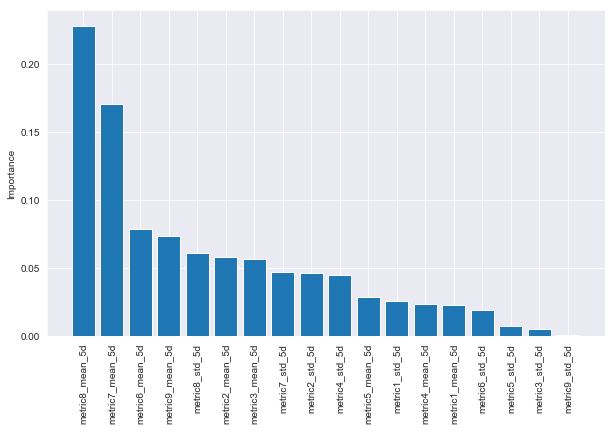

In [28]:
### Feature importance

import operator

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(feature_col, gb_model.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

#### Build predictive model of maintenance for sensors with more than 10 days of data

In [29]:
## Standardization of the values for prediction
print("labeled data: ",labeled_df.shape)
labeled_df = labeled_df[-labeled_df['id'].isin(sensors_less)]
print("labeled data (without short sensors): ",labeled_df.shape)

#X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.33, random_state=42)
# column names
feature_col = [col for col in labeled_df.columns if 'metric' in col]
label_col = ['failure']

test_sample_size=0.3

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(labeled_df[feature_col]), labeled_df[label_col], test_size=test_sample_size, random_state=42)

y_train = np.ravel(y_train,order='C')
y_test = np.ravel(y_test,order='C')

print("X_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("X_test: ",X_test.shape)
print("y_test: ",y_test.shape)

labeled data:  (119205, 21)
labeled data (without short sensors):  (118540, 21)
X_train:  (82978, 18)
y_train:  (82978,)
X_test:  (35562, 18)
y_test:  (35562,)


In [30]:
### Logistic regression model and prediction

logReg = LogisticRegression(solver = 'lbfgs', max_iter=500)
model = logReg.fit(X_train, y_train)
y_pred = logReg.predict(X_test)

print("logReg score: ",logReg.score(X_test, y_test))

print("F1 score: ",f1_score(y_test, y_pred, average='macro'))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

logReg score:  0.9974410888026545
F1 score:  0.5488643129550976


array([[35466,     4],
       [   87,     5]], dtype=int64)

In [37]:
## gradient boosting classifiers

gb = GradientBoostingClassifier(n_estimators=20, learning_rate = 0.50, max_features=2, max_depth = 5, random_state = 0)
gb_model = gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)


print("GB score: ",gb.score(X_test, y_test))

print("F1 score: ",f1_score(y_test, y_pred, average='macro'))

cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

GB score:  0.9947415780889713
F1 score:  0.6041662314044836


array([[35350,   120],
       [   67,    25]], dtype=int64)

Text(0, 0.5, 'Importance')

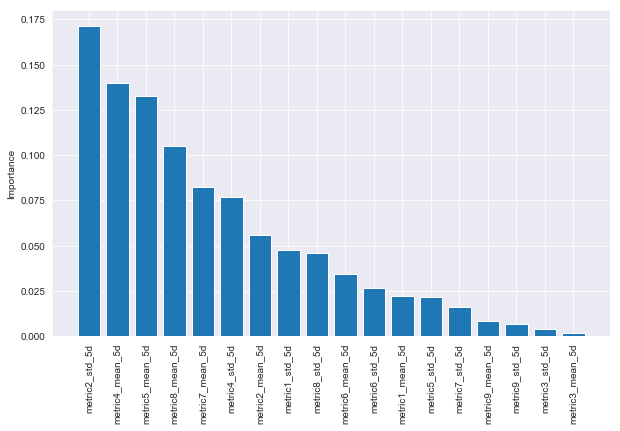

In [38]:
### Feature importance

import operator

sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))
labels, importances = zip(*sorted(zip(feature_col, gb_model.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')